In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi ['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [6]:
Xtr , Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 #  we don't want to add bias so we init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #back

    for p  in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


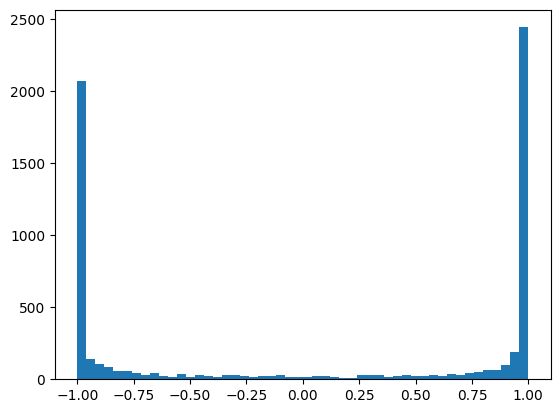

In [9]:
h # alot of values are at the limit of tanh

h.shape
plt.hist(h.view(-1).tolist(),50); # most values by far take on values at the extremes

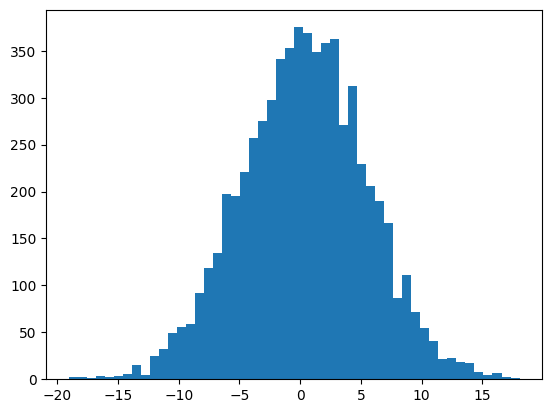

In [10]:
# We can look at why that is by lookig at the preactivations
plt.hist(hpreact.view(-1).tolist(),50); # most values by far take on values at the extremes
# very broad values between -20 and 20
# This is bad because of backpropagation step for tanh
# in backward pass we take out.grad and multiply it with the local gradient: -(1 - t**2) * out.grad
# if you plug out t==1 you're gonna get a zero multiplied by out.grad and killing the gradient
# When we input at exactly 0, out.grad is passed through
# I.e. when t=0 the tanh unit is inactive and gradient just passed thtough while the more you are in the flat tails
# the more the gradient is squashed

# The gradient through tanh can only ever decrease (1- t**2) and the ammount is proportional to where 
# you are in the flat tail of the tahn


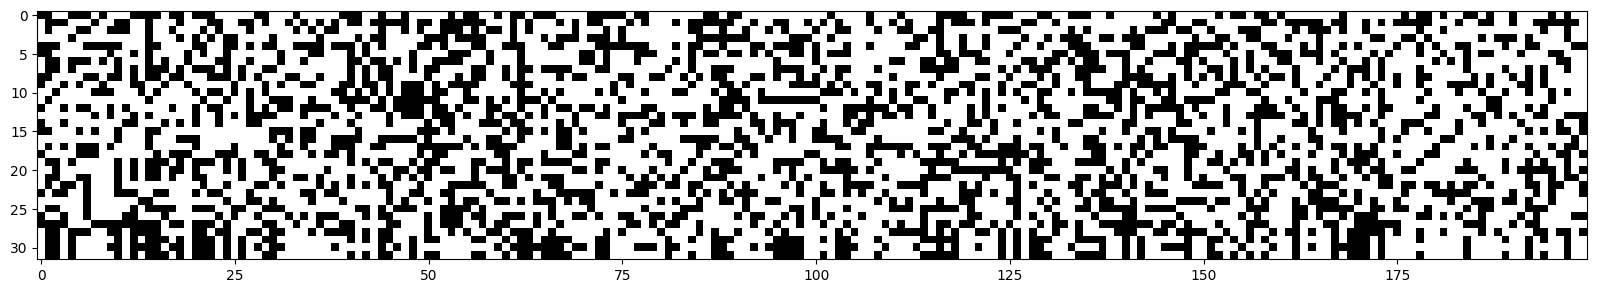

In [11]:
# We can get a sense of the problem as follows

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray",interpolation="nearest") # all white are in the flat tail and very active
                                                                # and the back gradient is destroyed
                                                                # if they were all white we have a dead neuron

# because there is no column of white we will be fine, however this is not optimal
# Again what happens is that the hpreact is too extreme and creating a distribution that is too saturated
# in both sides of the tanh meaning that there is less training for these neurons because they update less
# frequently

For a dead relu neuron
if a neuron with a relu non linearity never activates( always in the flat region) then this  relu neuron is a dead neuron and its weights and bias will never learn, will never activate and never get a gradient

This can happen at initialization by chance, with W and B making the neurons dead

Can also happen during optimization. when you have to high of a e.g: learning rate some of these neurons get to much of this gradient and get knocked out of the data manifold and from then on no example activates this neuron
so this neuron remains dead forever.
# Permanent brain damage 


In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtst, Ytst),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 3.1878931522369385
val 3.187795877456665
test 3.1874477863311768


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
def predict():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bn_gain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bn_bias

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out)) # decode and print the generated word

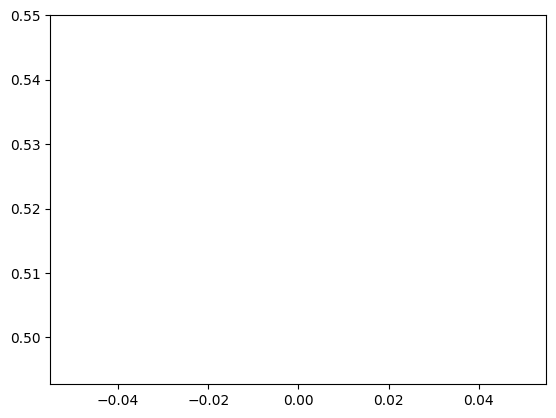

In [14]:
# problem
# Initialization
# at the 0-th iteration we are recording a loss of 25 which rapidly comes down to ~2
plt.plot(lossi)

In [15]:
# We want to assume at init that all 27 characters are equally likely
# probability for evey character should be 1./27.
# and then the loss is the negative log probability

-torch.tensor(1/27.0).log() # <-- the value that we should expect at initialization

tensor(3.2958)

In [16]:
# 4-dim example of the issue
#logits = torch.tensor([0.0,5.0,0.0,0.0])
logits =  torch.randn(4) * 10
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs, loss
# we could luck out and assign the right probability at initialization giving us a low loss
# More likely is that another value will have very high logit returing a very high  loss 


# We want the logits to be roughly equal
# but by simetry we want it to be all zeros and record the loss we expect at initialization

(tensor([9.8440e-01, 1.0082e-08, 1.5603e-02, 1.3018e-07]), tensor(4.1603))

In [17]:
# Fixing the dead neurons

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 #  we don't want to add bias so we init to 0


parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #back

    for p  in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


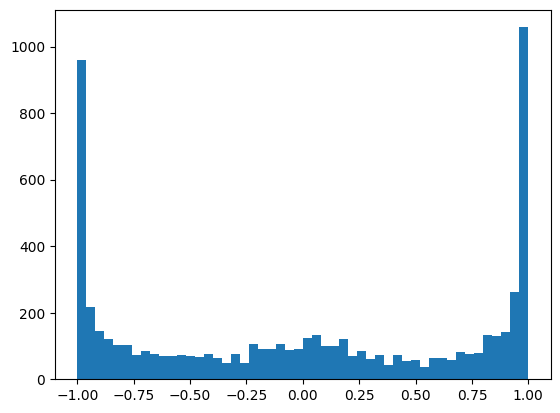

In [19]:
h # alot of values are at the limit of tanh

h.shape
plt.hist(h.view(-1).tolist(),50); # most values by far take on values at the extremes

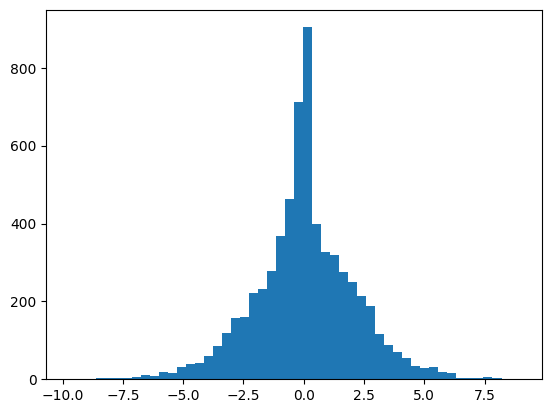

In [20]:
# We can look at why that is by lookig at the preactivations
plt.hist(hpreact.view(-1).tolist(),50); # most values by far take on values at the extremes
# very broad values between -20 and 20
# This is bad because of backpropagation step for tanh
# in backward pass we take out.grad and multiply it with the local gradient: -(1 - t**2) * out.grad
# if you plug out t==1 you're gonna get a zero multiplied by out.grad and killing the gradient
# When we input at exactly 0, out.grad is passed through
# I.e. when t=0 the tanh unit is inactive and gradient just passed thtough while the more you are in the flat tails
# the more the gradient is squashed

# The gradient through tanh can only ever decrease (1- t**2) and the ammount is proportional to where 
# you are in the flat tail of the tahn

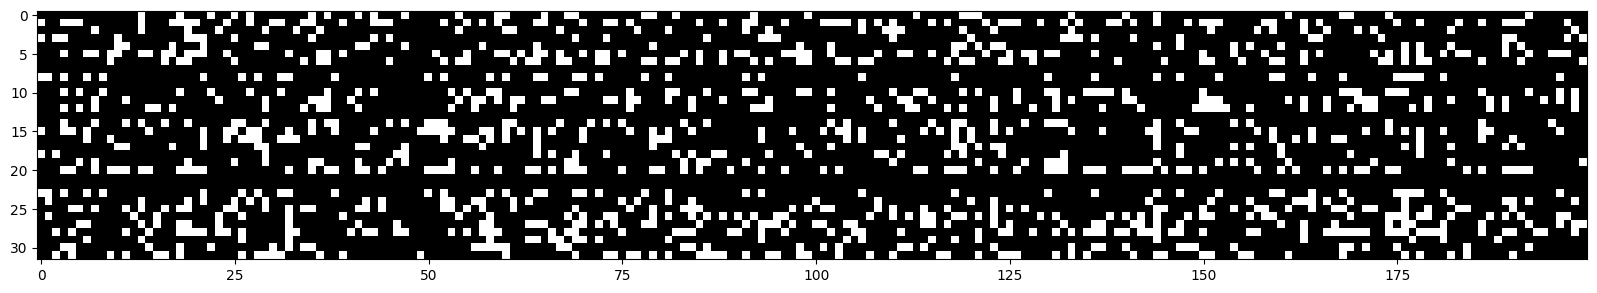

In [21]:
# We can get a sense of the problem as follows

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray",interpolation="nearest") # all white are in the flat tail and very active
                                                                # and the back gradient is destroyed
                                                                # if they were all white we have a dead neuron

# because there is no column of white we will be fine, however this is not optimal
# Again what happens is that the hpreact is too extreme and creating a distribution that is too saturated
# in both sides of the tanh meaning that there is less training for these neurons because they update less
# frequently

tensor(-0.0067) tensor(1.0097)
tensor(0.0010) tensor(0.9959)


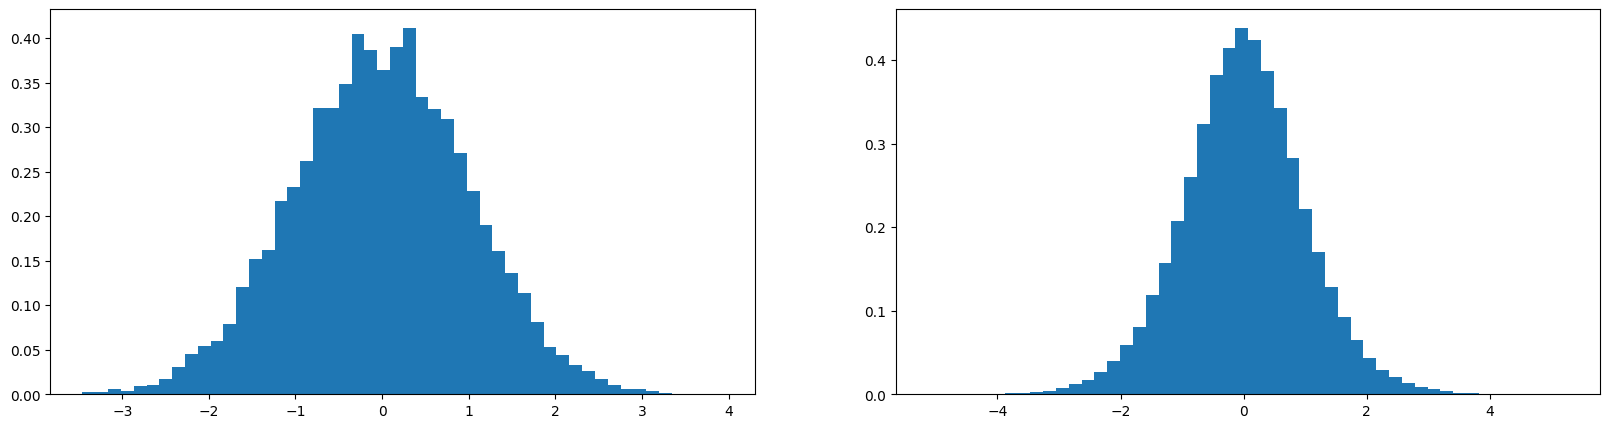

In [22]:
#How are we supposed to set the initialization with a lot of neurons and lots of layers
# input, weight initialized using gaussian
inp =  torch.randn(1000,10) # 1000 examples that are 10 dimensional
weight = torch.randn(10,200) / 10**0.5
out = inp @ weight
print(inp.mean(),inp.std()) # in the begining the mean and std is normal gaussian with mean = 0 and std = 1
print(out.mean(),out.std()) # once we multiply we see that the mean stays the same but the std changes
                            # so the gaussian changes and we do not want that
                            
                            # We want most of the neural net to have similar activations or unit gaussian 
                            # throughout the neural net
                            # The question becomes what do we use to multiply such that we preserve the standard
                            # deviation to be 1
                            # The answer is division by the squareroot of the fan_in
                            # i.e sqrt(input to the weights)
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(inp.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(out.view(-1).tolist(),50,density=True);

We want to make sure that the activations are well behaved and they do not expand to infinity or shrink to 0
So the question becomes how do we initialize the weights so these activations take reasonable values

# TO READ: Kaiminig Init Paper: https://arxiv.org/pdf/1502.01852 (Hard read)
    In the paper they investigate RELU which sets to 0 all negative numbers effectively throwing away half of
    the distribution you have to compensate for that with a gain
    
    Init weights with a 0 mean Gaussian, with std srt(2/fan_in) ----> They have to add in this factor of 2  because of the relu which basically discards half of the distribution 

    The paper also studies the backpropagation and we have to make sure that the gradients are also well behaved because they are the ones that ultimately update our parameters.

    What they find is that if you properly init the forward pass, the backward pass is also approximately properly initialized up to a constant factor that has to do with the size of the number of hidden neurons in an early and a late layer. They find that this is not a choice that matters to much


# Kaiming init in Pytorch: https://pytorch.org/docs/stable/nn.init.html 

mode - do you want to normalize the activations or the gradients to be gaussian with 0 mean and 1 std
nonlinearity . the gain that we are using

Due to modern inovations we don't have to pay that much attention to this step
Some of those inovations are:
    Residual connections
    Normalization Layers - Batch Normalization, Layer Normalization, Group Normalization
    Much better optimizers . RMSProp and Adam

In [23]:
(torch.randn(10000) * (5/3)).std()

tensor(1.6706)

In [24]:
(5/3) / (30 ** 0.5)
# lets use the kaiming initialization
# We want to do this because this will scale us to much bigger networks

0.3042903097250923

In [25]:
# Fixing the dead neurons

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)  #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 #  we don't want to add bias so we init to 0

bn_gain = torch.ones((1,n_hidden))
bn_bias = torch.zeros((1,n_hidden))
parameters = [C, W1, b1, W2, b2,bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [26]:
hpreact.mean(dim=0,keepdim=True).shape
hpreact.std(dim=0,keepdim=True).shape

torch.Size([1, 200])

In [27]:
max_steps = 200000
batch_size = 32
lossi = []

def train():
    for i in range(max_steps):
        ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        emb = C[Xb]
        embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
        hpreact = embcat @ W1 + b1 # hidden layer preactivation
        hpreact = bn_gain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bn_bias

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Yb)

        #back

        for p  in parameters:
            p.grad = None
        loss.backward()

        lr = 0.1 if i < 100000 else 0.01

        for p in parameters:
            p.data += -lr * p.grad

        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

In [28]:
train()

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [29]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtst, Ytst),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bn_gain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bn_bias

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0668270587921143
val 2.104844808578491
test 2.1064517498016357


In [30]:
hpreact = embcat @ W1 + b1
hpreact = bn_gain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bn_bias
hpreact.shape

torch.Size([32, 200])

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
def predict():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bn_gain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bn_bias

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out)) # decode and print the generated word

In [32]:
predict()

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

# NEXT TIME: BATCH NORMALIZATION

What we want in our preactivation states to be not to small because then its not doing anything
                                                   or to big because the tanh is saturated
                                                   in fact we want them to be roughly gaussian

What batch normalization does is that it normalizes those hidden states to be gaussian.

# Problem: we wont achieve a very good result with this because we want this to be roughly gaussian but only at initialization. We don't want this to always be forced to be gaussian, we want it to be more diffuse or more sharp, more trigger happy or less trigger happy. We want the backprop to tell us how that distribution should move around

# In addition to this idea, we want to add the scale and shift. We are taking the normalized hiddens states and scaling them by some gain and offsetting them by some bias to get the final output of the layer.

This controls the scale of the activation in the neural net and significantly

However the stability comes at a terrible cost it used to be that we have a single example feeding into the neural net and then we calculated the activation for these logits, making it a deterministic example where we arrive at these logits for these examples. Because of efficiency of training we are using batches of examples.

For a single example the activation will be a function of all the examples in the batch which are sampled randomly. So the activation will change depending on what other examples are in the batch. 
Its effectively padding out any one of these input examples an introducing a little bit of entropy and because of the padding out is like a little bit of data augumentation and its jittering it a bit making the neural net overfit to these concrete specific examples. 

-> Leads to alot of bugs
-> People have tried to move away from it with Layer Normalization, Instance Normalization, Group Normalization etc.



In [ ]:
# Another downfall is that you cannot predict with this
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
def predict():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bn_gain * (hpreact-hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bn_bias

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
predict() # < - RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [ ]:
# What you have to do is to calibrate the batchnorm at the end of the training

# This allows us to forward a single example because the mean and the std are fixed tensors
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0,keepdim=True)

# Instead of doing this as a separete step
# We can estimate the mean and std in a running manner as part of training

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtst, Ytst),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bn_gain * (hpreact-bnmean) / bnstd + bn_bias

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')
split_loss('test')

train 2.0668270587921143
val 2.1049270629882812
test 2.1064188480377197


In [ ]:
# Another downfall is that you cannot predict with this
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
def predict():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bn_gain * (hpreact-bnmean) /  bnstd  + bn_bias

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out)) # decode and print the generated word

In [ ]:
predict()

mora.
mayah.
see.
mad.
ryla.
reimastengraeg.
adelyn.
elin.
shi.
jen.
eden.
estanar.
kayzion.
kamin.
shubergahimie.
tri.
joselle.
jose.
casubelledi.
jamyleyeh.


In [ ]:
# Running mean and std in training

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) 
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 

bn_gain = torch.ones((1,n_hidden))
bn_bias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden)) # <- we don't derive gradients with batch norm
bnstd_running = torch.ones((1,n_hidden))   # <- updated on the side of training

parameters = [C, W1, W2, b2,bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# We can estimate the mean and std in a running manner as part of training

max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    # Linear Layer
    hpreact = embcat @ W1 #+ b1 # hidden layer preactivation
    # Batch Norm
    # ---------------------------------------------------------------
    bnmeani = hpreact.mean(0,keepdim=True) # Calculate the mean and
    bnstdi = hpreact.std(0,keepdim=True)   # std of the batch
    hpreact = bn_gain * (hpreact -bnmeani) / bnstdi + bn_bias # Centering the batch to be unit gaussian
                                                              # Afterwards it is offseting and scaling it by the
                                                              # learned bias and gain (Learned from backprop)
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backpropagation

    for p  in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [ ]:
embcat.shape, emb.shape, W1.shape # keep all examples, but concatenate the vectors such taht when we do
                        # matrix multiplication we get
                        # embcat @ W1
                        # 32 30
                        # 30 200 > 32 X 200

(torch.Size([32, 30]), torch.Size([32, 3, 10]), torch.Size([30, 200]))

In [ ]:
bnmean

tensor([[-2.3635,  0.6516, -0.9296,  1.0131,  1.1148,  1.1065,  1.7500, -2.0865,
          0.5698,  1.4275, -1.5500, -2.7530, -0.4690, -0.1472, -0.1063, -1.1543,
          0.6656, -2.6035, -0.1506,  1.6345, -0.7456, -0.3437,  0.0470,  0.5823,
          1.1275,  0.3645,  2.0326,  0.5844,  0.8224,  1.7610, -0.3324, -0.8291,
         -0.0850, -0.5156, -0.3988, -1.1034, -0.1101,  0.3484, -0.4990,  0.9976,
         -0.3881, -1.3013, -0.2704, -0.2132,  0.7647,  0.7007,  2.0737, -0.7674,
          2.3829,  1.8815,  0.8523,  0.3098,  1.8865,  0.4628,  0.6292, -1.9025,
         -0.0333,  0.4174,  1.3721, -0.9021, -0.4495,  1.1715,  0.5747,  0.6060,
          1.5892,  1.1536, -1.0216,  2.1587, -0.6779,  0.0361, -0.1987, -0.4753,
          1.0020, -1.0565, -2.9942,  0.6890,  1.4534, -0.1633,  0.0985,  0.5329,
          0.2373,  1.2848,  2.0482,  0.6390,  0.0567, -0.0821, -1.6929,  0.2850,
          2.2502, -0.0412, -0.6559,  1.3990, -0.7817, -1.2099, -1.0455,  0.2252,
          0.1931, -0.3624,  

In [ ]:
bnmean_running

tensor([[-2.3827,  0.6625, -0.9169,  1.0123,  1.1172,  1.0988,  1.7462, -2.1008,
          0.5567,  1.4061, -1.5605, -2.7572, -0.4807, -0.1576, -0.1004, -1.1379,
          0.6693, -2.6214, -0.1723,  1.6251, -0.7485, -0.3233,  0.0452,  0.5820,
          1.1284,  0.3649,  2.0366,  0.5780,  0.8205,  1.7659, -0.3439, -0.8333,
         -0.0831, -0.5183, -0.4011, -1.1031, -0.1103,  0.3365, -0.4956,  1.0026,
         -0.3961, -1.3248, -0.2725, -0.2098,  0.7676,  0.7096,  2.0717, -0.7825,
          2.3778,  1.8705,  0.8384,  0.3039,  1.8765,  0.4628,  0.6215, -1.9049,
         -0.0352,  0.4182,  1.3889, -0.9013, -0.4660,  1.1645,  0.5681,  0.6014,
          1.5889,  1.1376, -1.0280,  2.1529, -0.6705,  0.0490, -0.2058, -0.4730,
          0.9892, -1.0247, -2.9870,  0.6762,  1.4601, -0.1611,  0.0991,  0.5231,
          0.2352,  1.2731,  2.0206,  0.6485,  0.0630, -0.0874, -1.6973,  0.2893,
          2.2459, -0.0310, -0.6568,  1.4085, -0.7842, -1.2171, -1.0528,  0.2223,
          0.1734, -0.3667,  

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtst, Ytst),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bn_gain * (hpreact-bnmean_running) / bnstd_running + bn_bias

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')
split_loss('test')

train 2.066436290740967
val 2.105018138885498
test 2.1068742275238037


With batch norm we have inefciency whenever we have a linear or conv layer before the batch norm with the calculation of the bias. This is because whatever bias we add to the network will be subtracted when we substract the mean

# Residual layers

# Res net - the image feeds into a resnet and there are many layers with repeating structure.

Conv layers are used for images so they have spacial structure and the linear multiplication and bias addition are done on patches instead of the full input

In [116]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weights = torch.randn((fan_in,fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps =1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Training parameteres for backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Parameters for inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):

        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0,keepdim = True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x-xmean)/ torch.sqrt(xvar + self.eps)   # normalized  but unable to shift or scale
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [106]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),
]

# Initialization
with torch.no_grad():
    # make the last layer less confident
    layers[-1].weights *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [107]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

       

      0/ 200000: 3.2962


With weight gain of 1

layer 1 (      Tanh): mean -0.01, std 0.19, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.04, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.01, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.04, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.15, saturated: 0.00%


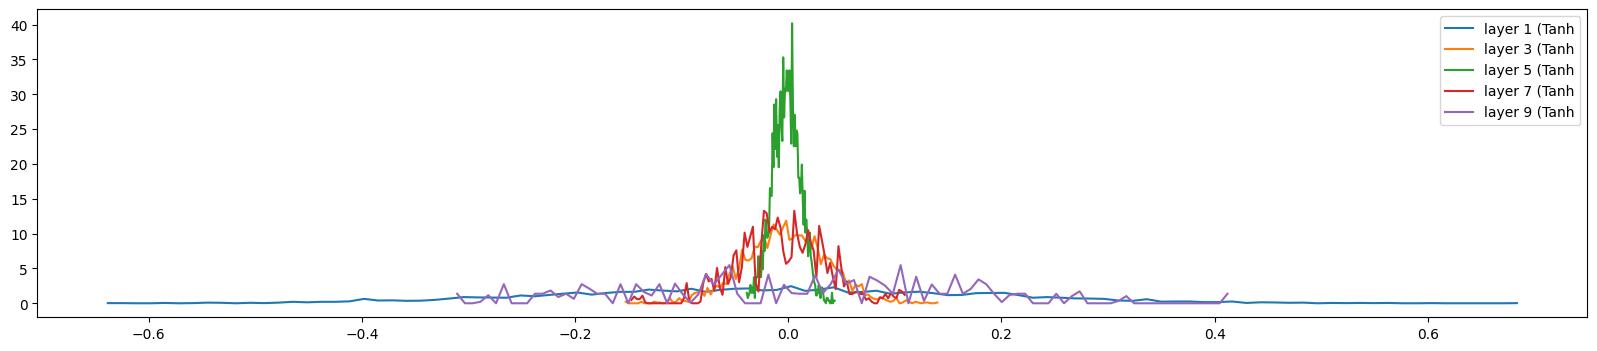

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);

We can see that the standard deviation is shrinking and the saturation os coming to 0

The first layer is pretty decent, but further layers are shrinking down to 0 and becoming more gaussian

The reason for that is that when we have a "sandwich" of linear layers along then initializing our weights with a  uniform distribution would have conserved the standard deviation of 1 but because we have the tanh layer in there
, these are squashing functions so they take the distribution and then slightly squash it and so some gain is necesary to keep expanding it and fight the squashing.

If its something to small e.g; 1 ->things will go to 0
But if its something to high e.g: 3 -> Saturations will be to large and create to saturated activations

If its right it will roughly stabilize the standard deviation at a resonable point with a good saturation

layer 1 (      Tanh): mean +0.000000, std 3.591344e-06
layer 3 (      Tanh): mean -0.000000, std 1.489005e-05
layer 5 (      Tanh): mean +0.000003, std 6.356524e-05
layer 7 (      Tanh): mean +0.000004, std 2.296797e-04
layer 9 (      Tanh): mean -0.000016, std 5.720156e-04


Text(0.5, 1.0, 'gradient distribution')

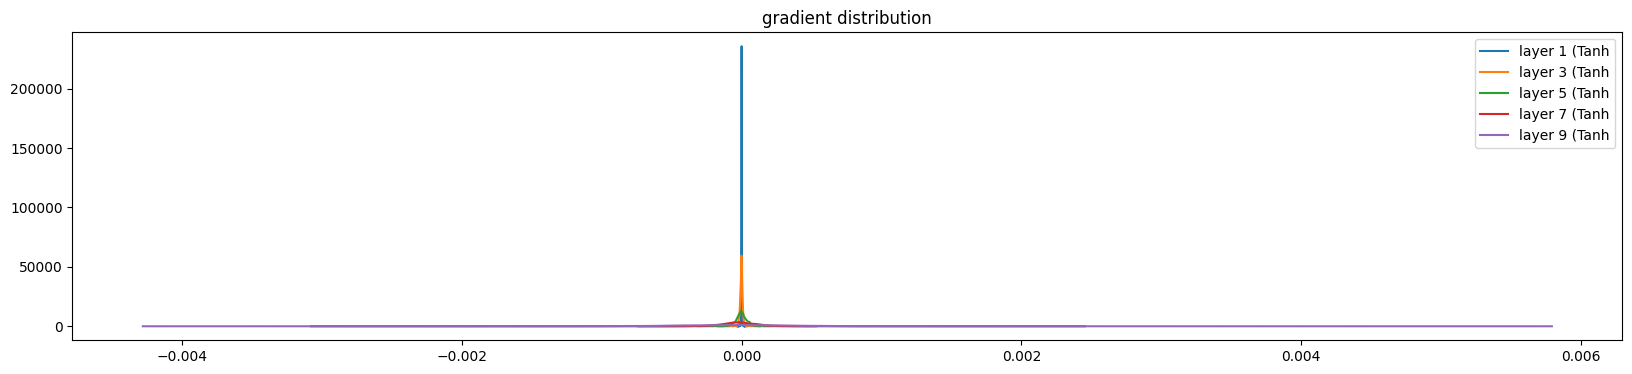

In [98]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# We can do the exact same thing with the gradients

Where we monitor the gradients

We want the gradient distribution to be fairly reasonable and we are looking at whether all the diferent layers in this "sandwhich" have roughly the same gradient and things are not shrinking or exploding

e.g: when the gain is way to small (as above) then we see the activations are shrinking to 0 but the gradients are expanding out flattening

e.g: when the gain is to big the activations are also changing but in the oposite direction and moving towards 0

# With weight gain of 5/3 for the tanh layers

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


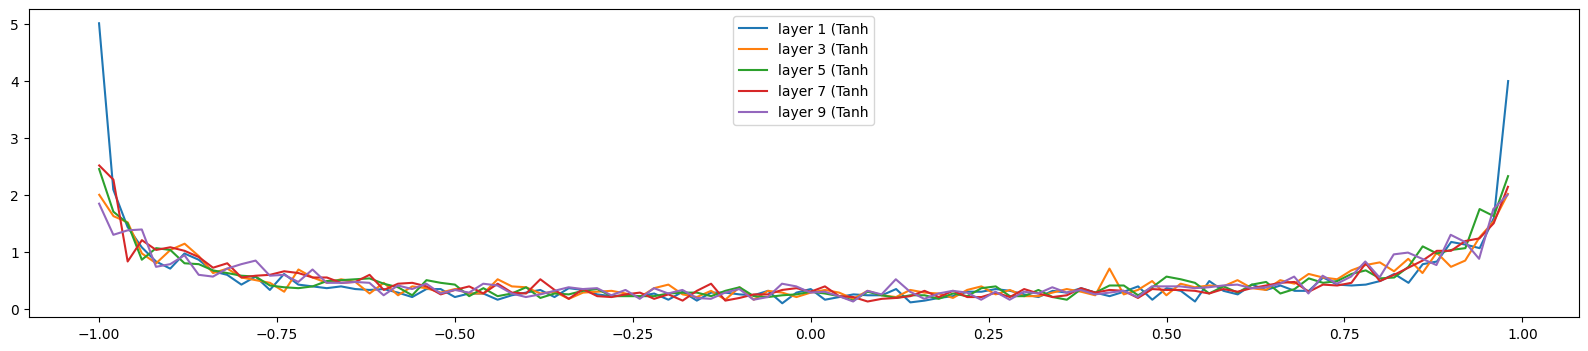

In [108]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);

layer 1 (      Tanh): mean +0.000024, std 3.353991e-03
layer 3 (      Tanh): mean +0.000012, std 3.157343e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

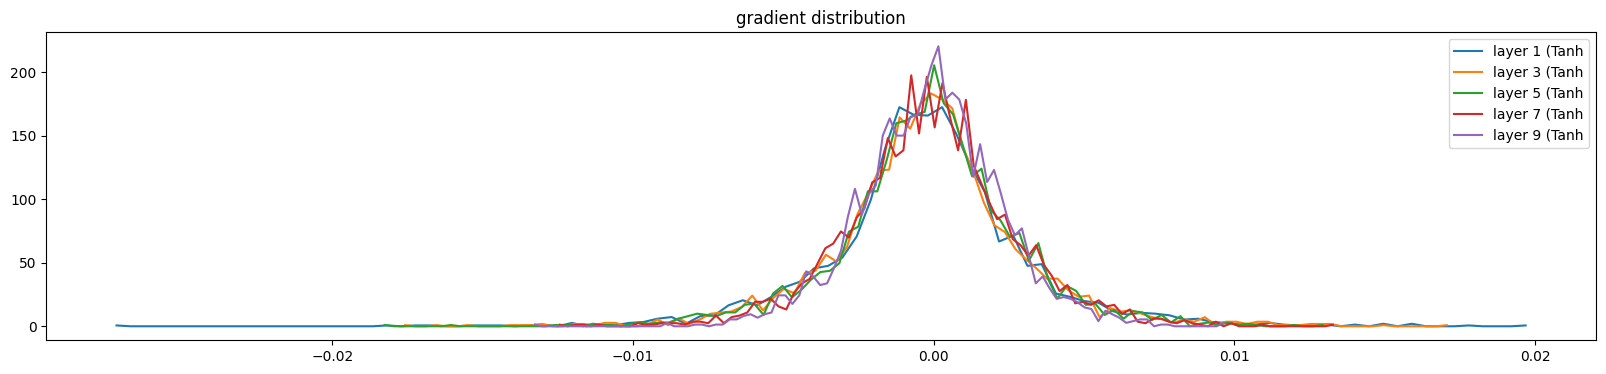

In [109]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad:data ratio 3.214555e-02
weight (100, 100) | mean +0.000033 | std 7.821210e-03 | grad:data ratio 4.653361e-02
weight (100, 100) | mean -0.000107 | std 6.655620e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086040e-03 | grad:data ratio 3.605767e-02
weight (100, 100) | mean -0.000077 | std 5.075619e-03 | grad:data ratio 3.015268e-02
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


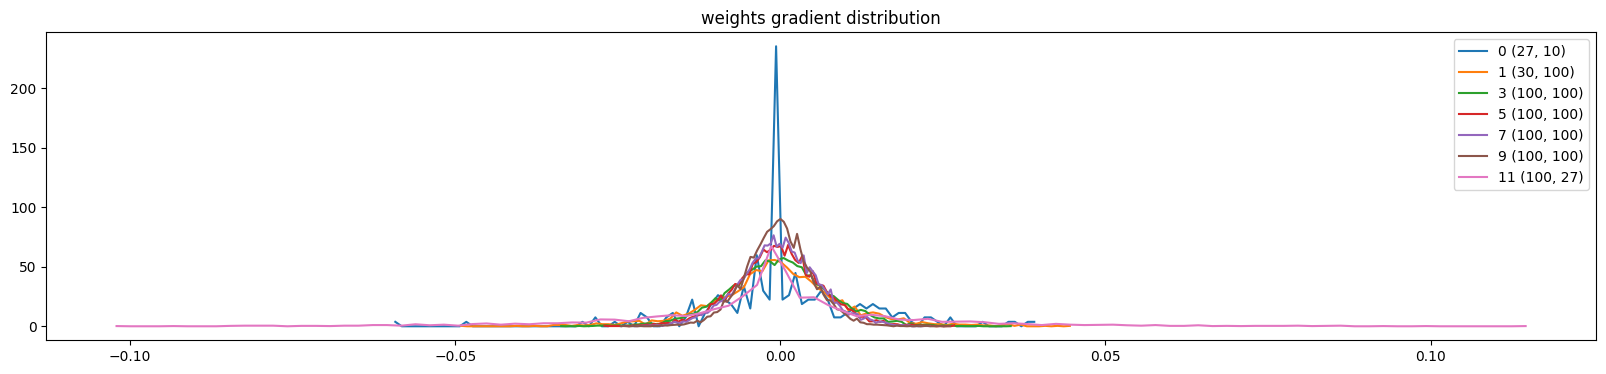

In [110]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# What does the weights gradient distribution plot tell us?

    grad:data ratio: It gives us a sense of what is the scale of the gradient compared to the scale of the actual values 
        this is important cause we are gonna take a step update that is the learning rate times the gradient onto the data and so -> if the data has to large of a magnitude then we are in trouble


With this setting wecan see that the last layer:
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01
takes on larger values than some of the values inside the neural net
    -> essentially we get that the values in this layer are much greater than all the other weights in the neural net (~10 times)

    This is problematic because that means we are training this layer 10 times faster than the other layers at initialization
    This fixes itself a bit after training for a few steps

# What matters in the end is not the gradient:data ratio but the update:data ratio because that is the ammount that we will change the data  in the tensors

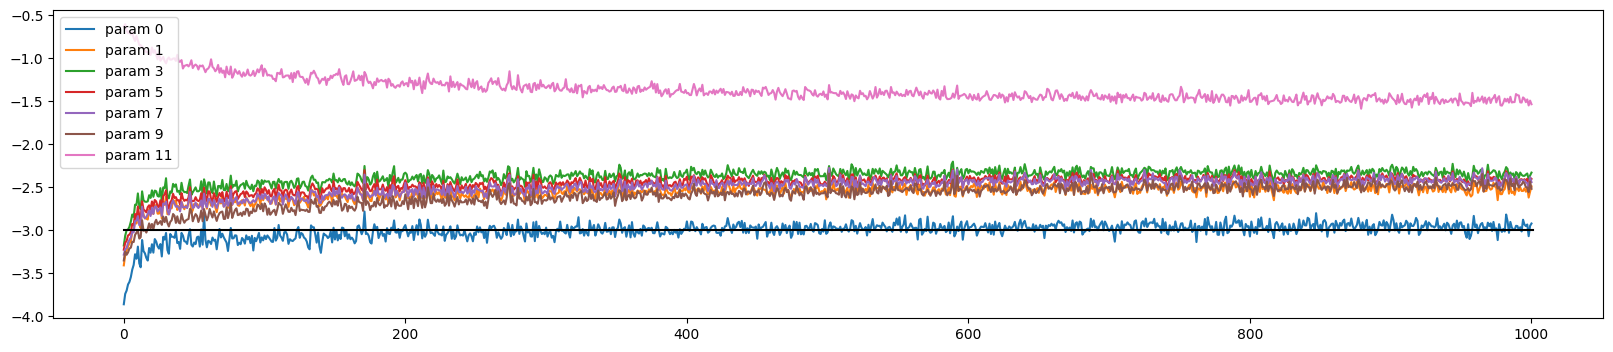

In [112]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);



If your learning rate is way to low, this plot will reveal it (every parameter will be bellow the line. The ratio should be around ~1e-3)

# Now with batch normalization

In [117]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),BatchNorm1d(vocab_size),
]

# Initialization
with torch.no_grad():
    # make the last layer less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weights *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [118]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


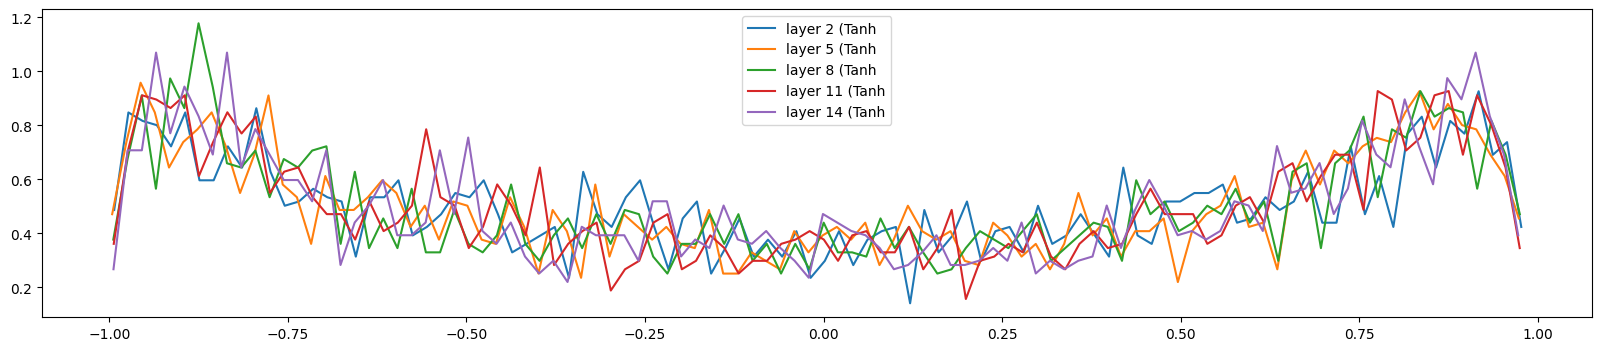

In [119]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);

layer 2 (      Tanh): mean -0.000000, std 3.682951e-03
layer 5 (      Tanh): mean +0.000000, std 3.262607e-03
layer 8 (      Tanh): mean +0.000000, std 2.973728e-03
layer 11 (      Tanh): mean -0.000000, std 2.741109e-03
layer 14 (      Tanh): mean -0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

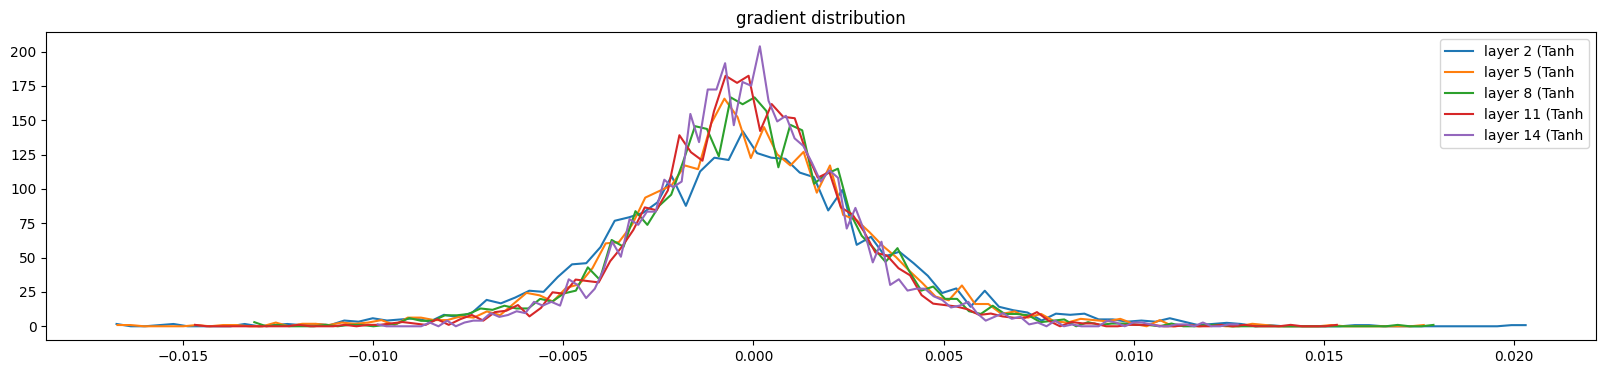

In [120]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.019885e-02 | grad:data ratio 1.018846e-02
weight  (30, 100) | mean +0.000092 | std 8.238425e-03 | grad:data ratio 2.635837e-02
weight (100, 100) | mean +0.000031 | std 7.318107e-03 | grad:data ratio 4.377142e-02
weight (100, 100) | mean -0.000019 | std 6.662022e-03 | grad:data ratio 3.949895e-02
weight (100, 100) | mean -0.000019 | std 5.821513e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445293e-03 | grad:data ratio 3.243365e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281260e-02


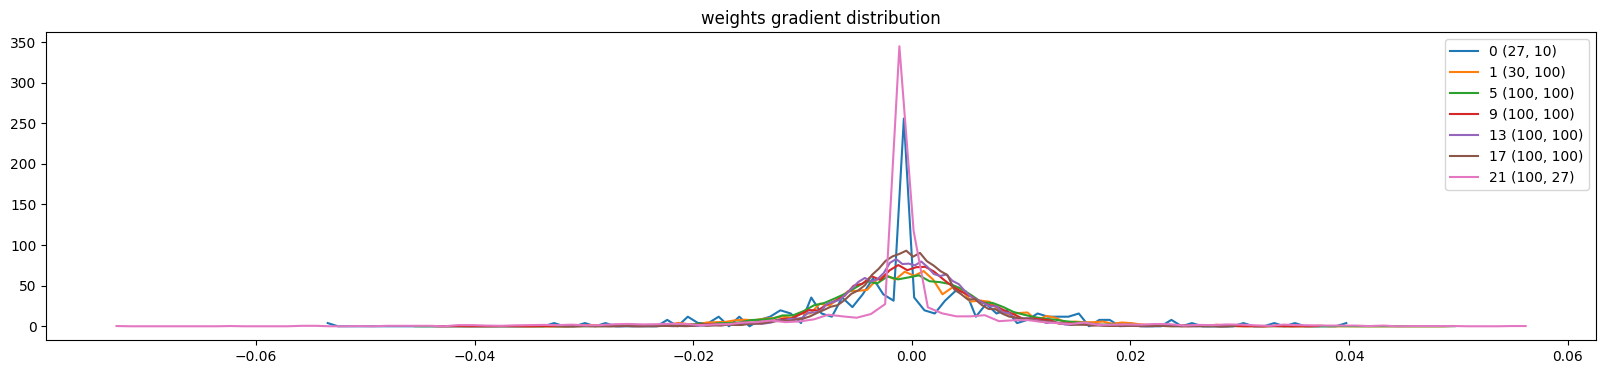

In [121]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

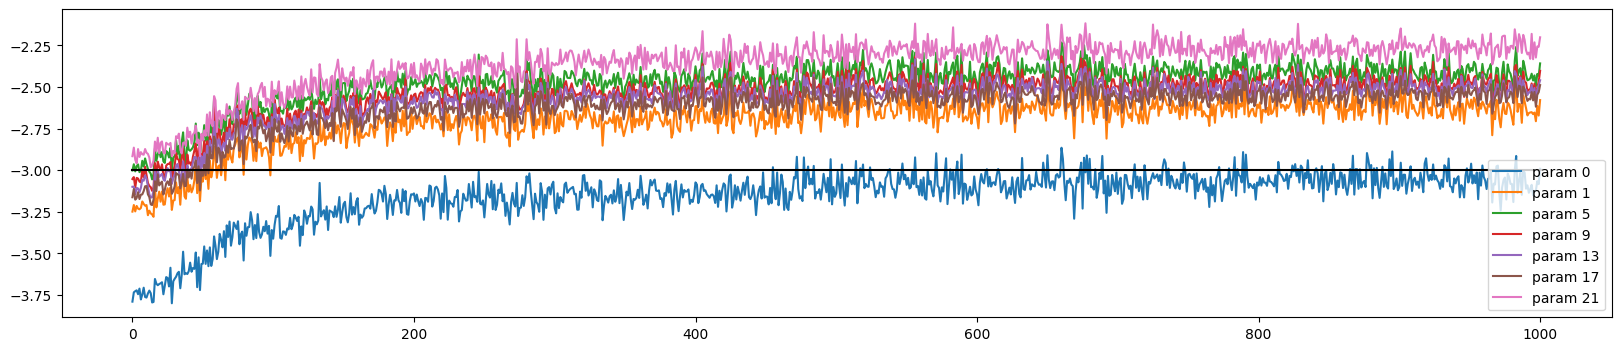

In [122]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


# With batch norm most of your data will look good, however the updates will change whenever you change the weight gain at the initialization of the neural net